In [1]:

#pip install lightgbm 


In [2]:

import  matplotlib.pyplot as plt
import pandas as pd
import datetime


import lightgbm
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_curve,auc,roc_auc_score,mean_squared_error
from sklearn.model_selection import train_test_split
import toad

pd.set_option("display.max_columns",50)

train_bank = pd.read_csv('./train_public.csv')

print(train_bank.shape)
train_bank.head()

(10000, 39)


,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.18182,3,11.466,1174.91,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1-Dec,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0
1,1025197,225197,28000.00000,5,16.841,670.69,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,Apr-90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0
2,1009360,209360,17272.72727,3,8.900,603.32,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,Oct-91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0
3,1039708,239708,20000.00000,3,4.788,602.30,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1-Jun,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0
4,1027483,227483,15272.72727,3,12.790,470.31,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2-May,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0


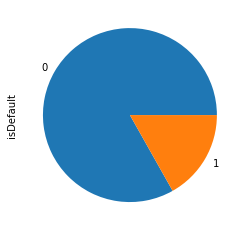

In [3]:
## 好坏样本的占比
train_bank.isDefault.value_counts().plot(kind='pie')


## 数据预处理

In [4]:
# 日期类型：issueDate 转换为pandas中的日期类型，加工出数值特征
train_bank['issue_date'] = pd.to_datetime(train_bank['issue_date'])
# 提取多尺度特征
train_bank['issue_date_y'] = train_bank['issue_date'].dt.year
train_bank['issue_date_m'] = train_bank['issue_date'].dt.month
# 提取时间diff # 转换为天为单位
base_time = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')   # 随机设置初始的基准时间
train_bank['issue_date_diff'] = train_bank['issue_date'].apply(lambda x: x-base_time).dt.days
# 可以发现earlies_credit_mon应该是年份-月的格式，这里简单提取年份
train_bank['earlies_credit_mon'] = train_bank['earlies_credit_mon'].map(lambda x:int(sorted(x.split('-'))[0]))
train_bank.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_y,issue_date_m,issue_date_diff
0,1040418,240418,31818.18182,3,11.466,1174.91,C,政府机构,金融业,3 years,0,1,2016-10-01,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0,2016,10,6118
1,1025197,225197,28000.00000,5,16.841,670.69,C,政府机构,金融业,10+ years,0,2,2013-06-01,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0,2013,6,4900
2,1009360,209360,17272.72727,3,8.900,603.32,A,政府机构,公共服务、社会组织,10+ years,1,0,2014-01-01,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0,2014,1,5114
3,1039708,239708,20000.00000,3,4.788,602.30,A,世界五百强,文化和体育业,6 years,0,1,2015-07-01,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0,2015,7,5660
4,1027483,227483,15272.72727,3,12.790,470.31,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016-07-01,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0,2016,7,6026


In [5]:
train_bank['employer_type'].value_counts()

普通企业       4610
政府机构       2474
幼教与中小学校    1053
上市企业        958
世界五百强       542
高等教育机构      363
Name: employer_type, dtype: int64

In [6]:
train_bank['industry'].value_counts()

金融业                1629
电力、热力生产供应业         1248
公共服务、社会组织          1065
住宿和餐饮业              907
信息传输、软件和信息技术服务业     808
文化和体育业              793
建筑业                 704
房地产业                554
采矿业                 506
交通运输、仓储和邮政业         492
农、林、牧、渔业            466
制造业                 302
批发和零售业              279
国际组织                247
Name: industry, dtype: int64

In [7]:
# 工作年限处理
train_bank['work_year'].fillna('10+ years', inplace=True)

work_year_map = {'10+ years': 10, '2 years': 2, '< 1 year': 0, '3 years': 3, '1 year': 1,
     '5 years': 5, '4 years': 4, '6 years': 6, '8 years': 8, '7 years': 7, '9 years': 9}
train_bank['work_year']  = train_bank['work_year'].map(work_year_map)

train_bank['class'] = train_bank['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

# 缺失值处理
train_bank = train_bank.fillna('9999')

In [8]:
# 区分 数值 或类别特征

drop_list = ['isDefault','earlies_credit_mon','loan_id','user_id','issue_date']
num_feas = []
cate_feas = []

for col in train_bank.columns:
    if col not in drop_list:
        try:
            train_bank[col] = pd.to_numeric(train_bank[col]) # 转为数值
            num_feas.append(col)
        except:
            train_bank[col] = train_bank[col].astype('category')
            cate_feas.append(col)
            
print(cate_feas)
print(num_feas)


['employer_type', 'industry']
['total_loan', 'year_of_loan', 'interest', 'monthly_payment', 'class', 'work_year', 'house_exist', 'censor_status', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status', 'app_type', 'title', 'policy_code', 'f0', 'f1', 'f2', 'f3', 'f4', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'issue_date_y', 'issue_date_m', 'issue_date_diff']


In [21]:
train_bank.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault,issue_date_y,issue_date_m,issue_date_diff
0,1040418,240418,31818.18182,3,11.466,1174.91,2,政府机构,金融业,3,0,1,2016-10-01,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,1,5,1,1.0,0.0,4.0,5.0,4.0,3,9927,0.0,0,2016,10,6118
1,1025197,225197,28000.00000,5,16.841,670.69,2,政府机构,金融业,10,0,2,2013-06-01,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,90,40642,1,7.0,0.0,4.0,45.0,22.0,0,0,0.0,0,2013,6,4900
2,1009360,209360,17272.72727,3,8.900,603.32,0,政府机构,公共服务、社会组织,10,1,0,2014-01-01,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,91,154,1,6.0,0.0,6.0,28.0,19.0,0,0,0.0,0,2014,1,5114
3,1039708,239708,20000.00000,3,4.788,602.30,0,世界五百强,文化和体育业,6,0,1,2015-07-01,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,1,0,1,5.0,0.0,10.0,15.0,9.0,0,0,0.0,0,2015,7,5660
4,1027483,227483,15272.72727,3,12.790,470.31,2,政府机构,信息传输、软件和信息技术服务业,0,2,1,2016-07-01,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,2,0,1,10.0,0.0,6.0,15.0,4.0,0,0,0.0,0,2016,7,6026


## LigthGBM训练

lgb树模型是集成学习的强模型，自带缺失、类别变量的处理，特征上面不用做很多处理，建模非常方便。

train  {'AUC': 0.8766158029476853, 'KS': 0.6579021970233876, 'f1': 0.5673795413553209, 'P': 0.40914158305462656, 'R': 0.9252100840336135}
test  {'AUC': 0.865667813691643, 'KS': 0.6284431987999525, 'f1': 0.5419664268585132, 'P': 0.38468085106382977, 'R': 0.9168356997971603}


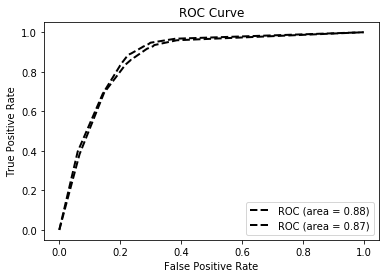

In [10]:

def model_metrics(model, x, y,nn=False):
    """ 评估 """
    
    if nn:
        yprob = model.predict(x.replace([np.inf, -np.inf], np.nan).fillna(0))[:,0]
        yhat = [1 if a>0.5 else 0 for a in yprob ]
    else:
        yhat = model.predict(x)
        yprob = model.predict_proba(x)[:,1]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    metrics = {'AUC':auc(fpr, tpr),'KS':max(tpr-fpr),
               'f1':f1_score(y,yhat),'P':precision_score(y,yhat),'R':recall_score(y,yhat)}
    
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


    return metrics


# 划分数据集：训练集和测试集
train_x, test_x, train_y, test_y = train_test_split(train_bank[num_feas + cate_feas], train_bank.isDefault,test_size=0.3, random_state=0)

# 训练模型
lgb=lightgbm.LGBMClassifier(n_estimators=5, num_leaves=5,class_weight= 'balanced',metric = 'AUC')
lgb.fit(train_x, train_y)
print('train ',model_metrics(lgb,train_x, train_y))
print('test ',model_metrics(lgb,test_x,test_y))


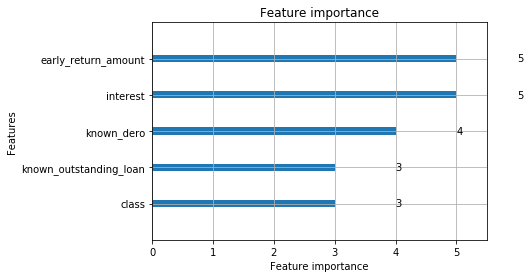

In [11]:
from lightgbm import plot_importance

plot_importance(lgb)

## LigthGBM输出叶子节点路径作为神经网络的入模特征

In [12]:
import numpy as np

y_pred = lgb.predict(train_bank[num_feas + cate_feas],pred_leaf=True) 

# 提取叶子节点
train_matrix = np.zeros([len(y_pred), len(y_pred[0])*lgb.get_params()['num_leaves']],dtype=np.int64)
print(train_matrix.shape) 


for i in range(len(y_pred)):
    temp = np.arange(len(y_pred[0]))*lgb.get_params()['num_leaves'] + np.array(y_pred[i])
    train_matrix[i][temp] += 1

(10000, 25)


In [13]:
# drop zero-features
df2 = pd.DataFrame(train_matrix)
droplist2 = []
for k in df2.columns:
    if not df2[k].any():
        droplist2.append(k)
print(len(droplist2))
df2= df2.drop(droplist2,axis=1).add_suffix('_lgb')

# # 拼接原特征和树节点特征
df_final2 = pd.concat([train_bank[num_feas],df2],axis=1)
df_final2.head()

0


,total_loan,year_of_loan,interest,monthly_payment,class,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,...,0_lgb,1_lgb,2_lgb,3_lgb,4_lgb,5_lgb,6_lgb,7_lgb,8_lgb,9_lgb,10_lgb,11_lgb,12_lgb,13_lgb,14_lgb,15_lgb,16_lgb,17_lgb,18_lgb,19_lgb,20_lgb,21_lgb,22_lgb,23_lgb,24_lgb
0,31818.18182,3,11.466,1174.91,2,3,0,1,2,193,13,2.430000,0,556.363636,649.090909,3,0,0.0,7734.230769,91.800000,0,0,5,1,1.0,...,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,28000.00000,5,16.841,670.69,2,10,0,2,0,491,30,11.004545,1,715.000000,893.750000,3,0,0.0,31329.000000,54.800000,1,0,40642,1,7.0,...,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,17272.72727,3,8.900,603.32,0,10,1,0,4,459,8,6.409091,0,774.545455,903.636364,5,0,0.0,18514.000000,57.692308,1,0,154,1,6.0,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,20000.00000,3,4.788,602.30,0,6,0,1,0,157,8,9.204545,0,750.000000,875.000000,3,0,0.0,20707.000000,42.600000,0,0,0,1,5.0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,15272.72727,3,12.790,470.31,2,0,2,1,0,38,21,15.578182,0,609.090909,710.606061,15,0,0.0,14016.153850,30.461538,0,0,0,1,10.0,...,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


## lgb节点路径输入神经网络模型

In [14]:
# 划分数据集：训练集和测试集
train_x, test_x, train_y, test_y = train_test_split(df_final2, train_bank.isDefault,test_size=0.3, random_state=0)

# 神经网络模型评估
def model_metrics2(nnmodel, x, y):
    yprob = nnmodel.predict(x.replace([np.inf, -np.inf], np.nan).fillna(0))[:,0]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    return auc(fpr, tpr),max(tpr-fpr)

************隐藏层vs神经元数vs norm************** 0 1 0.01
验证集最优结果： 0.29361435770988464 0.3072504997253418
219/219 [==============================] - 0s 647us/step
------------train------------
 (0.8877466408250048, 0.661293915156424)
94/94 [==============================] - 0s 666us/step
------------test------------
 (0.8714026688760316, 0.6311334349015454)
94/94 [==============================] - 0s 630us/step
************隐藏层vs神经元数vs norm************** 0 1 0.05
验证集最优结果： 0.2934732139110565 0.30637699365615845
219/219 [==============================] - 0s 599us/step
------------train------------
 (0.8885316536253055, 0.6622152475448011)
94/94 [==============================] - 0s 629us/step
------------test------------
 (0.8727417187250952, 0.6318632372966242)
94/94 [==============================] - 0s 590us/step
************隐藏层vs神经元数vs norm************** 0 1 0.1
验证集最优结果： 0.2933485507965088 0.30645930767059326
219/219 [==============================] - 0s 642us/step
------------train--------

219/219 [==============================] - 0s 766us/step
------------train------------
 (0.8676969583013927, 0.654156120279437)
94/94 [==============================] - 0s 794us/step
------------test------------
 (0.8537296381490853, 0.6071575653080099)
94/94 [==============================] - 0s 789us/step
************隐藏层vs神经元数vs norm************** 0 16 0.01
验证集最优结果： 0.29341745376586914 0.306869775056839
219/219 [==============================] - 0s 1ms/step
------------train------------
 (0.8879823254603045, 0.6611724207755392)
94/94 [==============================] - 0s 913us/step
------------test------------
 (0.8713484596072174, 0.6319562830565288)
94/94 [==============================] - 0s 984us/step
************隐藏层vs神经元数vs norm************** 0 16 0.05
验证集最优结果： 0.29443663358688354 0.3056201636791229
219/219 [==============================] - 0s 1ms/step
------------train------------
 (0.8872913984871057, 0.6616482737673384)
94/94 [==============================] - 0s 1ms/step
--

94/94 [==============================] - 0s 672us/step
------------test------------
 (0.8730257105661955, 0.6312944445208588)
94/94 [==============================] - 0s 654us/step
************隐藏层vs神经元数vs norm************** 0 26 0.8
验证集最优结果： 0.5019984245300293 21.9561824798584
219/219 [==============================] - 0s 751us/step
------------train------------
 (0.5, 0.0)
94/94 [==============================] - 0s 783us/step
------------test------------
 (0.5, 0.0)
94/94 [==============================] - 0s 746us/step
************隐藏层vs神经元数vs norm************** 0 31 0.01
验证集最优结果： 0.29435819387435913 0.30629876255989075
219/219 [==============================] - 0s 988us/step
------------train------------
 (0.887240631192236, 0.6652627315986636)
94/94 [==============================] - 0s 858us/step
------------test------------
 (0.8737449947449374, 0.6301997409282407)
94/94 [==============================] - 0s 813us/step
************隐藏层vs神经元数vs norm************** 0 31 0.05
验证集最优结果：

94/94 [==============================] - 0s 657us/step
************隐藏层vs神经元数vs norm************** 0 41 0.6
验证集最优结果： 0.2939273416996002 0.3065192401409149
219/219 [==============================] - 0s 639us/step
------------train------------
 (0.8876336076599315, 0.6616381492355978)
94/94 [==============================] - 0s 653us/step
------------test------------
 (0.8727109731696483, 0.6330259047486511)
94/94 [==============================] - 0s 668us/step
************隐藏层vs神经元数vs norm************** 0 41 0.8
验证集最优结果： 0.293109655380249 0.3077158033847809
219/219 [==============================] - 0s 687us/step
------------train------------
 (0.8881926264481697, 0.6652424825351828)
94/94 [==============================] - 0s 640us/step
------------test------------
 (0.8707715758958082, 0.6285362445598571)
94/94 [==============================] - 0s 653us/step
************隐藏层vs神经元数vs norm************** 0 46 0.01
验证集最优结果： 0.2942279875278473 0.30609428882598877
219/219 [==================

94/94 [==============================] - 0s 972us/step
************隐藏层vs神经元数vs norm************** 0 56 0.4
验证集最优结果： 0.29330307245254517 0.30586108565330505
219/219 [==============================] - 0s 705us/step
------------train------------
 (0.8884252014058637, 0.6650906145590766)
94/94 [==============================] - 0s 704us/step
------------test------------
 (0.8745427609994249, 0.6295039204628663)
94/94 [==============================] - 0s 726us/step
************隐藏层vs神经元数vs norm************** 0 56 0.6
验证集最优结果： 0.296783447265625 0.3065636456012726
219/219 [==============================] - 0s 618us/step
------------train------------
 (0.8852057449485818, 0.6633491950997266)
94/94 [==============================] - 0s 678us/step
------------test------------
 (0.8726470547780617, 0.6309975071827281)
94/94 [==============================] - 0s 661us/step
************隐藏层vs神经元数vs norm************** 0 56 0.8
验证集最优结果： 0.29341867566108704 0.3066272437572479
219/219 [=================

验证集最优结果： 0.29385820031166077 0.30545419454574585
219/219 [==============================] - 0s 624us/step
------------train------------
 (0.8876446000086782, 0.6650197428368938)
94/94 [==============================] - 0s 696us/step
------------test------------
 (0.8753081635113367, 0.6307005698445973)
94/94 [==============================] - 0s 656us/step
************隐藏层vs神经元数vs norm************** 0 71 0.4
验证集最优结果： 0.294744074344635 0.3084664046764374
219/219 [==============================] - 0s 612us/step
------------train------------
 (0.8866930386612475, 0.6601802166649793)
94/94 [==============================] - 0s 646us/step
------------test------------
 (0.8698880457234955, 0.6309975071827281)
94/94 [==============================] - 0s 738us/step
************隐藏层vs神经元数vs norm************** 0 71 0.6
验证集最优结果： 0.29328495264053345 0.3064420223236084
219/219 [==============================] - 0s 732us/step
------------train------------
 (0.8881120641027496, 0.6631467044649184)
94/9

219/219 [==============================] - 0s 622us/step
------------train------------
 (0.8886049841623397, 0.6627417231953022)
94/94 [==============================] - 0s 592us/step
------------test------------
 (0.8697925726828978, 0.6287401361380831)
94/94 [==============================] - 0s 610us/step
************隐藏层vs神经元数vs norm************** 0 86 0.2
验证集最优结果： 0.293437659740448 0.30603477358818054
219/219 [==============================] - 0s 651us/step
------------train------------
 (0.8883569331346997, 0.6632783233775439)
94/94 [==============================] - 0s 793us/step
------------test------------
 (0.8736940218503807, 0.6298348397307012)
94/94 [==============================] - 0s 779us/step
************隐藏层vs神经元数vs norm************** 0 86 0.4
验证集最优结果： 0.29366713762283325 0.3060063123703003
219/219 [==============================] - 0s 665us/step
------------train------------
 (0.8878363875670752, 0.664877999392528)
94/94 [==============================] - 0s 832us/ste

219/219 [==============================] - 0s 836us/step
------------train------------
 (0.5, 0.0)
94/94 [==============================] - 0s 877us/step
------------test------------
 (0.5, 0.0)
94/94 [==============================] - 0s 838us/step
************隐藏层vs神经元数vs norm************** 1 1 0.1
验证集最优结果： 0.6218491196632385 0.4814644455909729
219/219 [==============================] - 0s 836us/step
------------train------------
 (0.8394865416045937, 0.652212210185279)
94/94 [==============================] - 0s 801us/step
------------test------------
 (0.8257406644761807, 0.6296738301113879)
94/94 [==============================] - 0s 849us/step
************隐藏层vs神经元数vs norm************** 1 1 0.2
验证集最优结果： 0.4573920965194702 0.4484509229660034
219/219 [==============================] - 0s 834us/step
------------train------------
 (0.5, 0.0)
94/94 [==============================] - 0s 746us/step
------------test------------
 (0.5, 0.0)
94/94 [==============================] - 0s 752us/

94/94 [==============================] - 0s 826us/step
************隐藏层vs神经元数vs norm************** 1 16 0.05
验证集最优结果： 0.3289647400379181 0.33281537890434265
219/219 [==============================] - 0s 757us/step
------------train------------
 (0.8839175429207828, 0.6600384732206135)
94/94 [==============================] - 0s 784us/step
------------test------------
 (0.8721789941510627, 0.6333228420867818)
94/94 [==============================] - 0s 763us/step
************隐藏层vs神经元数vs norm************** 1 16 0.1
验证集最优结果： 0.34574660658836365 0.3457857668399811
219/219 [==============================] - 0s 765us/step
------------train------------
 (0.8851660423205426, 0.6589146501974285)
94/94 [==============================] - 0s 758us/step
------------test------------
 (0.8728978737830221, 0.6330598866783554)
94/94 [==============================] - 0s 753us/step
************隐藏层vs神经元数vs norm************** 1 16 0.2
验证集最优结果： 0.3916381001472473 0.37891003489494324
219/219 [===============

94/94 [==============================] - 0s 862us/step
************隐藏层vs神经元数vs norm************** 1 31 0.01
验证集最优结果： 0.3103049695491791 0.3186224699020386
219/219 [==============================] - 0s 929us/step
------------train------------
 (0.8890565382779616, 0.6674293813911107)
94/94 [==============================] - 0s 873us/step
------------test------------
 (0.8767912320148613, 0.6360559601472874)
94/94 [==============================] - 0s 859us/step
************隐藏层vs神经元数vs norm************** 1 31 0.05
验证集最优结果： 0.3427966237068176 0.34565576910972595
219/219 [==============================] - 0s 720us/step
------------train------------
 (0.8840871288274346, 0.6612736660929431)
94/94 [==============================] - 0s 702us/step
------------test------------
 (0.8749197986004301, 0.6316593457183981)
94/94 [==============================] - 0s 741us/step
************隐藏层vs神经元数vs norm************** 1 31 0.1
验证集最优结果： 0.37217673659324646 0.37421682476997375
219/219 [==============

94/94 [==============================] - 0s 704us/step
************隐藏层vs神经元数vs norm************** 1 41 0.8
验证集最优结果： 0.714117169380188 0.6835237741470337
219/219 [==============================] - 0s 677us/step
------------train------------
 (0.3735936302231736, 0.001204819277108471)
94/94 [==============================] - 0s 672us/step
------------test------------
 (0.37651492656262264, 0.0)
94/94 [==============================] - 0s 686us/step
************隐藏层vs神经元数vs norm************** 1 46 0.01
验证集最优结果： 0.3171261250972748 0.32355138659477234
219/219 [==============================] - 0s 657us/step
------------train------------
 (0.8879087779690189, 0.6652323580034424)
94/94 [==============================] - 0s 676us/step
------------test------------
 (0.8772847790891387, 0.6390431335870111)
94/94 [==============================] - 0s 650us/step
************隐藏层vs神经元数vs norm************** 1 46 0.05
验证集最优结果： 0.34775081276893616 0.351284921169281
219/219 [=============================

94/94 [==============================] - 0s 712us/step
************隐藏层vs神经元数vs norm************** 1 56 0.6
验证集最优结果： 0.6996070742607117 0.6811408400535583
219/219 [==============================] - 0s 669us/step
------------train------------
 (0.8457635343293943, 0.6375620127569099)
94/94 [==============================] - 0s 636us/step
------------test------------
 (0.8297974596080266, 0.608558106267967)
94/94 [==============================] - 0s 659us/step
************隐藏层vs神经元数vs norm************** 1 56 0.8
验证集最优结果： 0.7873808741569519 0.7620974183082581
219/219 [==============================] - 0s 688us/step
------------train------------
 (0.8041932917745411, 0.576217474941784)
94/94 [==============================] - 0s 667us/step
------------test------------
 (0.8000802620815874, 0.5623200272502713)
94/94 [==============================] - 0s 673us/step
************隐藏层vs神经元数vs norm************** 1 61 0.01
验证集最优结果： 0.31739404797554016 0.32431161403656006
219/219 [==================

94/94 [==============================] - 0s 677us/step
************隐藏层vs神经元数vs norm************** 1 71 0.4
验证集最优结果： 0.6652488112449646 0.6527897119522095
219/219 [==============================] - 0s 1ms/step
------------train------------
 (0.8503887820188316, 0.6504100435354865)
94/94 [==============================] - 0s 1ms/step
------------test------------
 (0.8484430207993683, 0.6279674517840917)
94/94 [==============================] - 0s 1ms/step
************隐藏层vs神经元数vs norm************** 1 71 0.6
验证集最优结果： 0.7659061551094055 0.7494939565658569
219/219 [==============================] - 0s 913us/step
------------train------------
 (0.7975246243075543, 0.5216057507340286)
94/94 [==============================] - 0s 982us/step
------------test------------
 (0.7813380142093012, 0.5111950231036668)
94/94 [==============================] - 0s 774us/step
************隐藏层vs神经元数vs norm************** 1 71 0.8
验证集最优结果： 0.8840917944908142 0.857312023639679
219/219 [==========================

94/94 [==============================] - 0s 1ms/step
************隐藏层vs神经元数vs norm************** 1 86 0.2
验证集最优结果： 0.5817100405693054 0.5719907283782959
219/219 [==============================] - 0s 1ms/step
------------train------------
 (0.8750519967022954, 0.6540245013668118)
94/94 [==============================] - 0s 1ms/step
------------test------------
 (0.8671605913179407, 0.6364459432453228)
94/94 [==============================] - 0s 1ms/step
************隐藏层vs神经元数vs norm************** 1 86 0.4
验证集最优结果： 0.7083113789558411 0.6937657594680786
219/219 [==============================] - 0s 1ms/step
------------train------------
 (0.8120805189545698, 0.5610306773311734)
94/94 [==============================] - 0s 993us/step
------------test------------
 (0.8017340493271983, 0.5612342236868613)
94/94 [==============================] - 0s 971us/step
************隐藏层vs神经元数vs norm************** 1 86 0.6
验证集最优结果： 0.8295636773109436 0.8149835467338562
219/219 [=============================

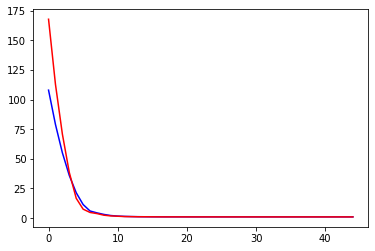

Model: "sequential_279"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_279 (Ba  (None, 60)               240       
 tchNormalization)                                               
                                                                 
 dense_418 (Dense)           (None, 96)                5856      
                                                                 
 dropout_139 (Dropout)       (None, 96)                0         
                                                                 
 dense_419 (Dense)           (None, 1)                 97        
                                                                 
Total params: 6,193
Trainable params: 6,073
Non-trainable params: 120
_________________________________________________________________
['bestval, layer_nums, k, norm', 0.8783831236027965, 1, 81, 0.01]


In [15]:

import keras
from keras import regularizers
from keras.layers import Dense,Dropout,BatchNormalization,GaussianNoise
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import  mean_squared_error


np.random.seed(1) # 固定随机种子，使每次运行结果固定



bestval = 0
# 创建神经模型并暴力搜索较优网络结构超参： 输入层；   n层k个神经元的relu隐藏层；  输出层
for layer_nums in range(2): #隐藏层的层数
    for k in list(range(1,100,5)):  # 网格神经元数
        for norm in [0.01,0.05,0.1,0.2,0.4,0.6,0.8]:#正则化惩罚系数
            print("************隐藏层vs神经元数vs norm**************",layer_nums,k,norm)
            model = Sequential()
            model.add(BatchNormalization())  # 输入层 批标准化  input_dim=train_x.shape
            for _ in range(layer_nums):
                model.add(Dense(k,  
                                kernel_initializer='random_uniform',   # 均匀初始化
                                activation='relu',                     # relu激活函数
                                kernel_regularizer=regularizers.l1_l2(l1=norm, l2=norm),  # L1及L2 正则项
                                use_bias=True))   # 隐藏层1
                model.add(Dropout(norm)) # dropout正则
            model.add(Dense(1,use_bias=True,activation='sigmoid'))  # 输出层


            # 编译模型：优化目标为回归预测损失mse，优化算法为adam
            model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy) 

            # 训练模型
            history = model.fit(train_x.replace([np.inf, -np.inf], np.nan).fillna(0), 
                                train_y, 
                                epochs=1000,              # 训练迭代次数
                                batch_size=1000,           # 每epoch采样的batch大小
                                validation_data=(test_x.replace([np.inf, -np.inf], np.nan).fillna(0),test_y),   # 从训练集再拆分验证集，作为早停的衡量指标
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10)],    #早停法
                                verbose=False)  # 不输出过程  
            print("验证集最优结果：",min(history.history['loss']),min(history.history['val_loss']))
            print('------------train------------\n',model_metrics2(model, train_x,train_y))

            print('------------test------------\n',model_metrics2(model, test_x,test_y))
            test_auc = model_metrics2(model, test_x,test_y)[0] 
            if test_auc > bestval:
                bestval = test_auc
                bestparas = ['bestval, layer_nums, k, norm',bestval, layer_nums, k, norm]


# 模型评估：拟合效果
plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()
model.summary()   #模型概述信息
print(bestparas)
    

In [20]:
## 最优神经网络参数验证
#########配置最优网络参数######
norm=0.01
layer_nums =1
k=81
np.random.seed(1) # 固定随机种子，使每次运行结果固定
#########配置最优网络参数######

model = Sequential()
model.add(BatchNormalization())  # 输入层 批标准化  input_dim=train_x.shape
for _ in range(layer_nums):
    model.add(Dense(k,  
                    kernel_initializer='random_uniform',   # 均匀初始化
                    activation='relu',                     # relu激活函数
                    kernel_regularizer=regularizers.l1_l2(l1=norm, l2=norm),  # L1及L2 正则项
                    use_bias=True))   # 隐藏层1
model.add(Dropout(norm)) # dropout正则
model.add(Dense(1,use_bias=True,activation='sigmoid'))  # 输出层


# 编译模型：优化目标为回归预测损失mse，优化算法为adam
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy) 

# 训练模型
history = model.fit(train_x.replace([np.inf, -np.inf], np.nan).fillna(0), 
                    train_y, 
                    epochs=1000,              # 训练迭代次数
                    batch_size=1000,           # 每epoch采样的batch大小
                    validation_data=(test_x.replace([np.inf, -np.inf], np.nan).fillna(0),test_y),   # 从训练集再拆分验证集，作为早停的衡量指标
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],    #早停法
                    verbose=False)  # 不输出过程  


print('------------train------------\n',model_metrics2(model, train_x,train_y))

print('------------test------------\n',model_metrics2(model, test_x,test_y))
model.summary()   #模型概述信息

219/219 [==============================] - 0s 757us/step
------------train------------
 (0.8857634620113105, 0.662488609901792)
94/94 [==============================] - 0s 783us/step
------------test------------
 (0.8776610075965795, 0.6361829878368965)
Model: "sequential_284"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_284 (Ba  (None, 60)               240       
 tchNormalization)                                               
                                                                 
 dense_428 (Dense)           (None, 81)                4941      
                                                                 
 dropout_144 (Dropout)       (None, 81)                0         
                                                                 
 dense_429 (Dense)           (None, 1)                 82        
                                                              